<h1>Link Prediction in Social Network Graph</h1>

<h2>Problem Statement</h2>
Given a directed social graph, e.g., FB/Insta friends or X-followers, etc. Predict the missing links to recommend users.

<h2>Data Source and Overview</h2>
Data is taken from the FB's recruiting challenge on Kaggle.</br>
Data contain two columns, namely:
<ul>
    <li>source_node</li>
    <li>destination_node</li>
</ul>


<h2>Transforming the Problem into Supervised Learning Problem</h2>

<ul>
    <li>Balance the data by generating the training samples of good and bad links from a given directed graph. Good means that between any two given nodes of the graph have edge, and bad refers to the pair of nodes in graph which has no edge. </li>
   <li>Problem becomes ``Binary Classification Problem". </li>
   <li>Feature engineering is performed. For each link got some features like no. of the followers (indegree), how many he followed back (outdegree), page rank, Katz score, adar index, svd features of the adj. matrix, some weight features, etc. </li>
    <li> Train the ML model, especially, RF, based on these features to predict the link</li>
    
</ul>

<h2>Business Objectives and Constraints</h2>
<ul>
    <li>No low latency requirements.</li>
     <li>Probability of prediction is useful to recommend link.</li>
</ul>


<h2>Performance Metric  for Supervised Learning </h2>
<ul>
    <li>Confusion Matrix, Precision and Recall.</li>
     <li>F-1 Score</li>
</ul>

<h2>EDA</h2>

In [1]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle

In [2]:
#Reading the graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    train_csv=pd.read_csv('data/train.csv')
    print(train_csv[train_csv.isna().any(1)])
    print(train_csv.info())
    print("Number of duplicate entries: ", sum(train_csv.duplicated()))
    train_csv.to_csv('data/after_eda/train_woheader.csv', header=False, index=False)
    print("Saved the graph.")
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv', delimiter=',', create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


DiGraph with 66 nodes and 50 edges


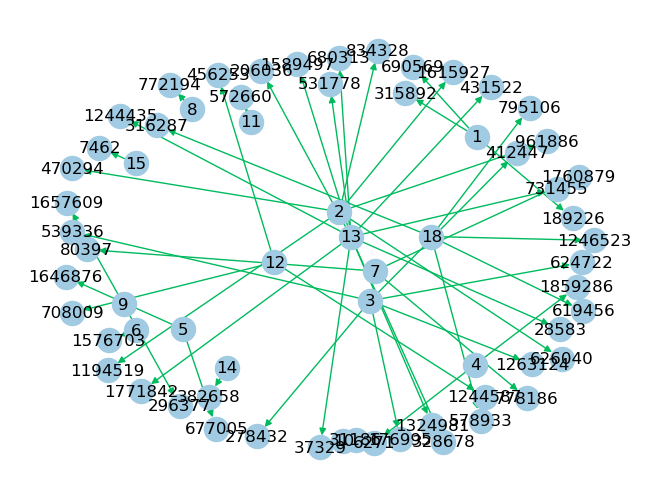

In [3]:
#Displaying Subgraph
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv', header=False, index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv', delimiter=',', create_using=nx.DiGraph(),nodetype=int) 
pos=nx.spring_layout(subgraph)
nx.draw(subgraph, pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))
    

<h3> 1. Exploratory Data Analysis</h3>
<h4>1.1. Number of Followers of Each Person</h4>


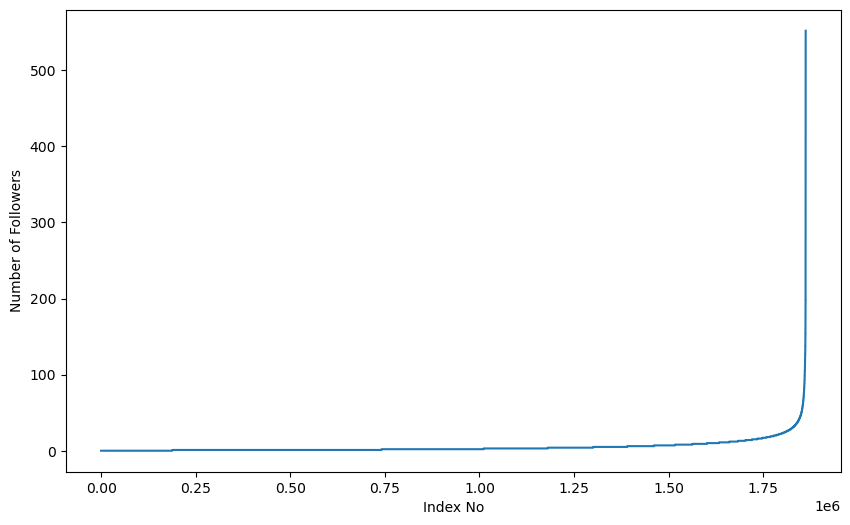

In [4]:
indegree_dist=list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist)
plt.xlabel("Index No")
plt.ylabel("Number of Followers")
plt.show()


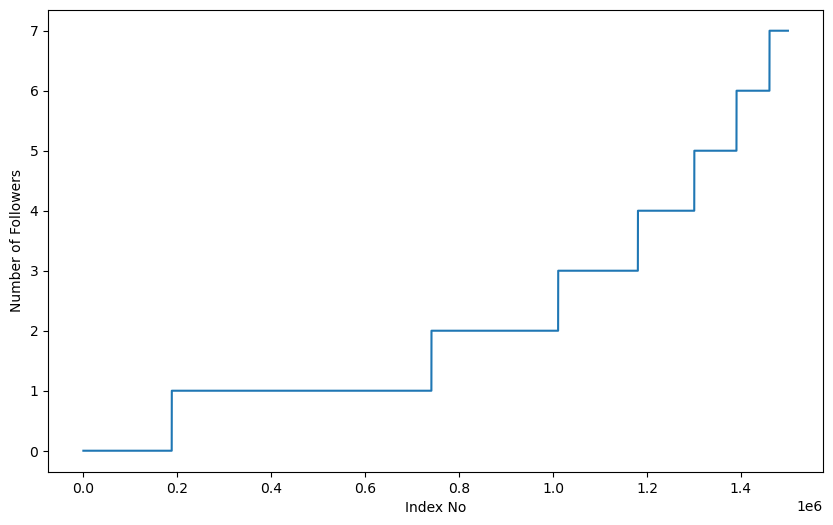

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel("Index No")
plt.ylabel("Number of Followers")
plt.show()

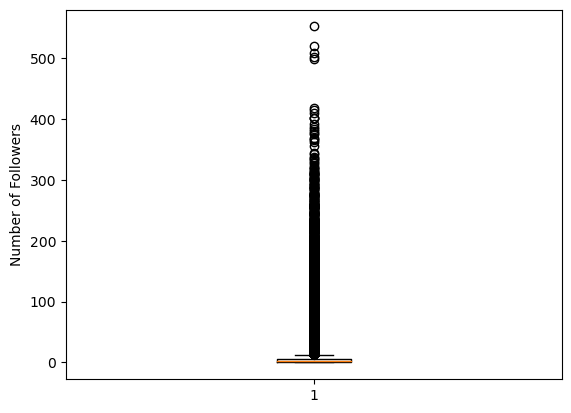

In [6]:
plt.boxplot(indegree_dist)
plt.ylabel("Number of Followers")
plt.show()


In [7]:
#90+ percentiles
for i in range(0, 11):
    print(90+i," percentile value is: ", np.percentile(indegree_dist,90+i))

90  percentile value is:  12.0
91  percentile value is:  13.0
92  percentile value is:  14.0
93  percentile value is:  15.0
94  percentile value is:  17.0
95  percentile value is:  19.0
96  percentile value is:  21.0
97  percentile value is:  24.0
98  percentile value is:  29.0
99  percentile value is:  40.0
100  percentile value is:  552.0


In [8]:
#Most of the users have 40 or less folowers. Also:
for i in range(10, 110,10):
    print(99+ (i/100)," percentile value is: ", np.percentile(indegree_dist,99+(i/100)))


99.1  percentile value is:  42.0
99.2  percentile value is:  44.0
99.3  percentile value is:  47.0
99.4  percentile value is:  50.0
99.5  percentile value is:  55.0
99.6  percentile value is:  61.0
99.7  percentile value is:  70.0
99.8  percentile value is:  84.0
99.9  percentile value is:  112.0
100.0  percentile value is:  552.0


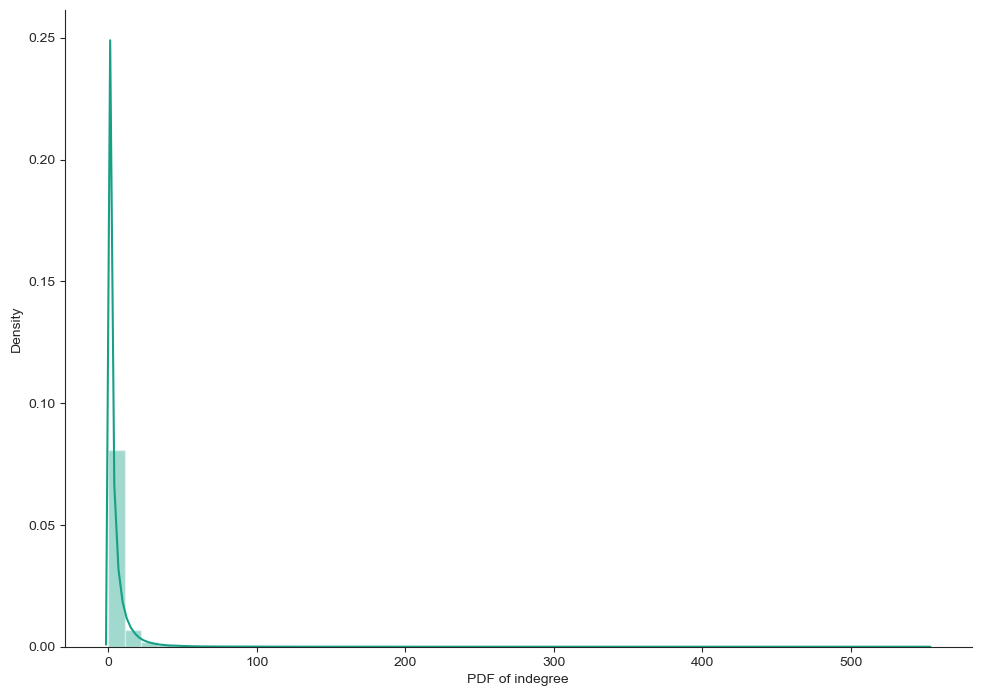

In [9]:
%matplotlib inline
sns.set_style('ticks')
fig, ax=plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel("PDF of indegree")
sns.despine()

<h4>1.2. Number of People Each Person is Following</h4>

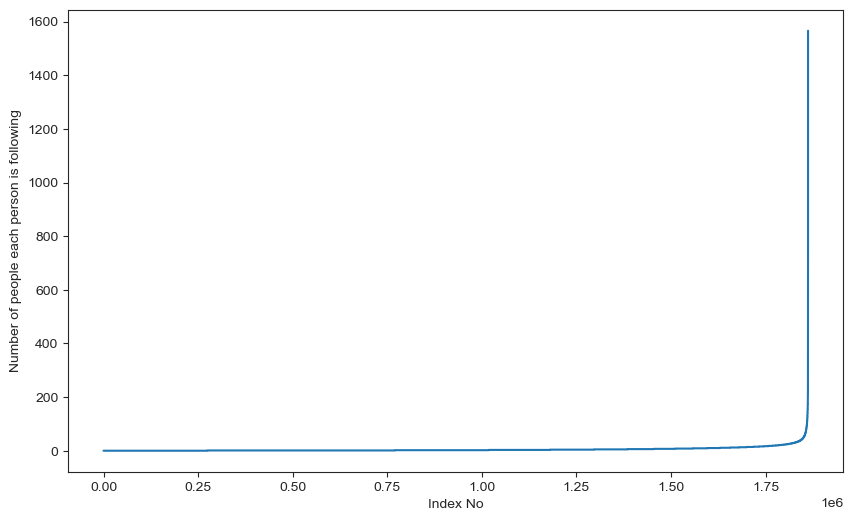

In [10]:
outdegree_dist=list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(outdegree_dist)
plt.xlabel("Index No")
plt.ylabel("Number of people each person is following")
plt.show()

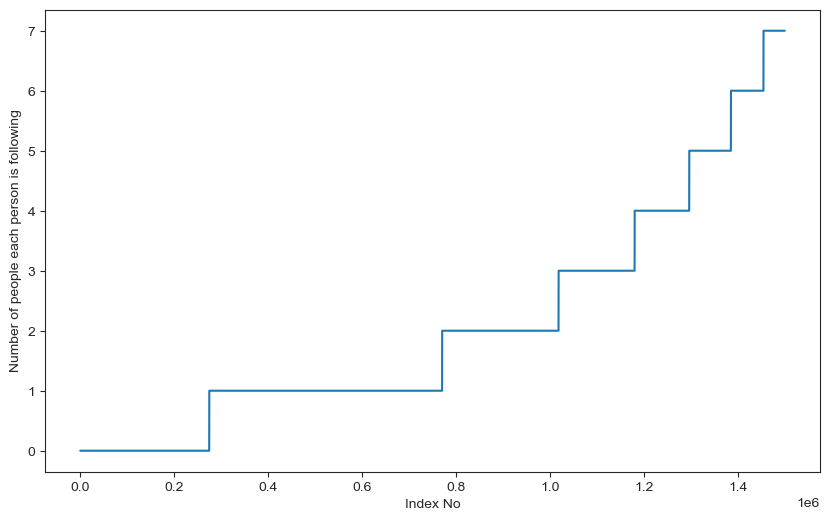

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel("Index No")
plt.ylabel("Number of people each person is following")
plt.show()

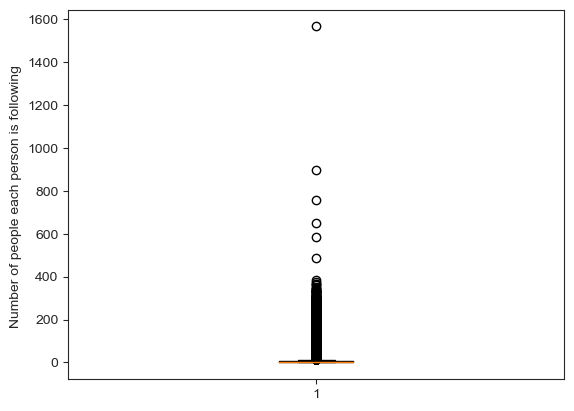

In [12]:
plt.boxplot(outdegree_dist)
plt.ylabel("Number of people each person is following ")
plt.show()

In [13]:
#90+ percentiles
for i in range(0, 11):
    print(90+i," percentile value is: ", np.percentile(outdegree_dist,90+i))

90  percentile value is:  12.0
91  percentile value is:  13.0
92  percentile value is:  14.0
93  percentile value is:  15.0
94  percentile value is:  17.0
95  percentile value is:  19.0
96  percentile value is:  21.0
97  percentile value is:  24.0
98  percentile value is:  29.0
99  percentile value is:  40.0
100  percentile value is:  1566.0


In [14]:
#Most of the users are following 40 or less people. Also:
for i in range(10, 110,10):
    print(99+ (i/100)," percentile value is: ", np.percentile(outdegree_dist,99+(i/100)))

99.1  percentile value is:  42.0
99.2  percentile value is:  45.0
99.3  percentile value is:  48.0
99.4  percentile value is:  52.0
99.5  percentile value is:  56.0
99.6  percentile value is:  63.0
99.7  percentile value is:  73.0
99.8  percentile value is:  90.0
99.9  percentile value is:  123.0
100.0  percentile value is:  1566.0


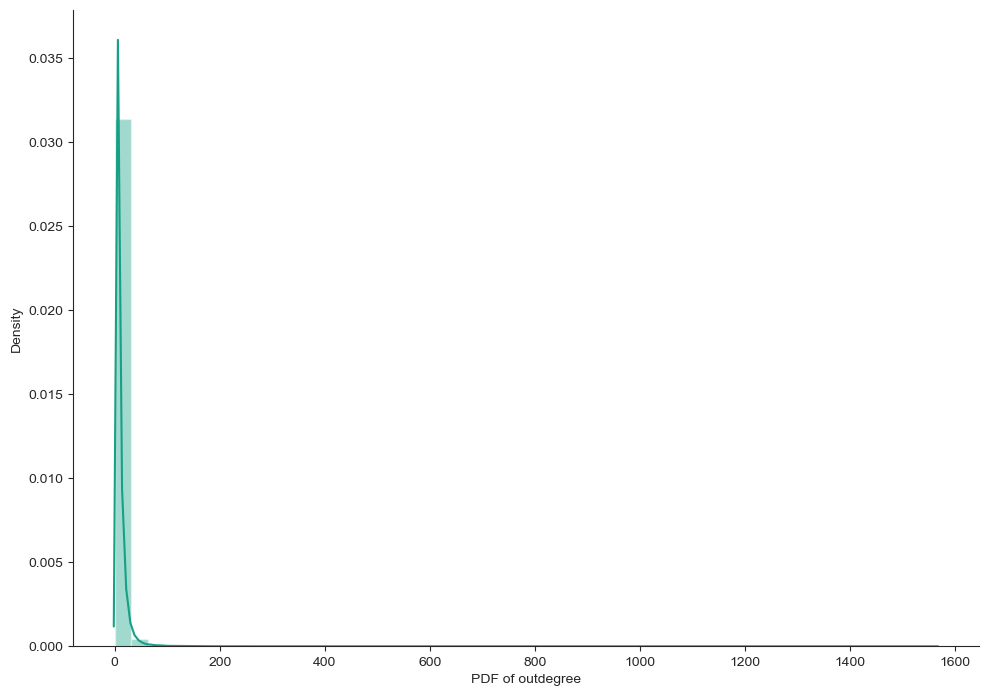

In [15]:
%matplotlib inline
sns.set_style('ticks')
fig, ax=plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel("PDF of outdegree")
sns.despine()

In [16]:
print("Number of persons those are not following anyone are: ", sum(np.array(outdegree_dist)==0), 'and  % is: ', sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

Number of persons those are not following anyone are:  274512 and  % is:  14.741115442858524


In [17]:
print("Number of persons having zero followers are: ", sum(np.array(indegree_dist)==0), 'and  % is: ', sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

Number of persons having zero followers are:  188043 and  % is:  10.097786512871734


In [18]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0:
        if len(list(g.successors(i)))==0:
            count +=1
print("The number of people those are not followed by anyone and are not following anyone: ", count)            

The number of people those are not followed by anyone and are not following anyone:  0


<h4>1.3. Both Followers and Followings </h4>

In [19]:
from collections import Counter

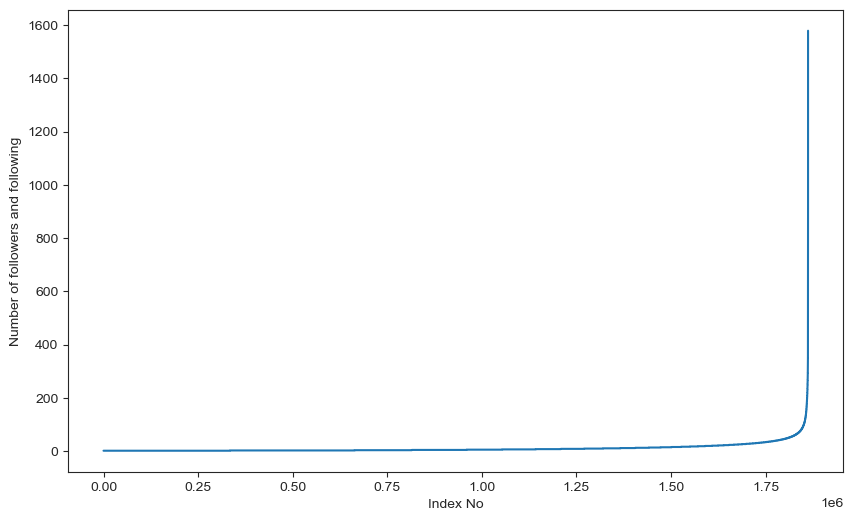

In [20]:
dict_in=dict(g.in_degree())
dict_out=dict(g.out_degree())
d=Counter(dict_in)+Counter(dict_out)
in_out_degree=np.array(list(d.values()))
in_out_degree_sort=sorted(in_out_degree)
plt.figure(figsize=(10, 6))
plt.plot(in_out_degree_sort)
plt.xlabel("Index No")
plt.ylabel("Number of followers and following")
plt.show()




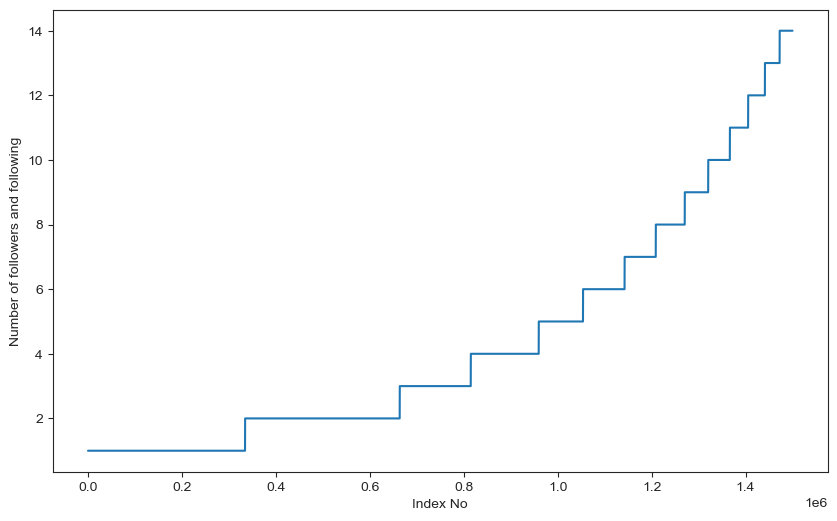

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel("Index No")
plt.ylabel("Number of followers and following")
plt.show()

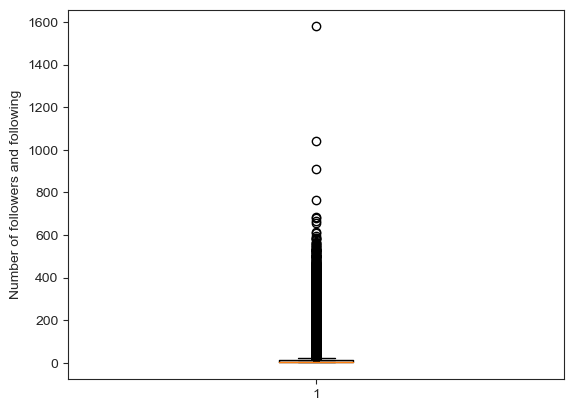

In [22]:
plt.boxplot(in_out_degree_sort)
plt.ylabel("Number of followers and following")
plt.show()

In [23]:
#90+ percentiles
for i in range(0, 11):
    print(90+i," percentile value is: ", np.percentile(in_out_degree_sort,90+i))

90  percentile value is:  24.0
91  percentile value is:  26.0
92  percentile value is:  28.0
93  percentile value is:  31.0
94  percentile value is:  33.0
95  percentile value is:  37.0
96  percentile value is:  41.0
97  percentile value is:  48.0
98  percentile value is:  58.0
99  percentile value is:  79.0
100  percentile value is:  1579.0


In [24]:
#Most of the users have 79 or less coonections or (followers + followings). Also:
for i in range(10, 110,10):
    print(99+ (i/100)," percentile value is: ", np.percentile(in_out_degree_sort,99+(i/100)))

99.1  percentile value is:  83.0
99.2  percentile value is:  87.0
99.3  percentile value is:  93.0
99.4  percentile value is:  99.0
99.5  percentile value is:  108.0
99.6  percentile value is:  120.0
99.7  percentile value is:  138.0
99.8  percentile value is:  168.0
99.9  percentile value is:  221.0
100.0  percentile value is:  1579.0


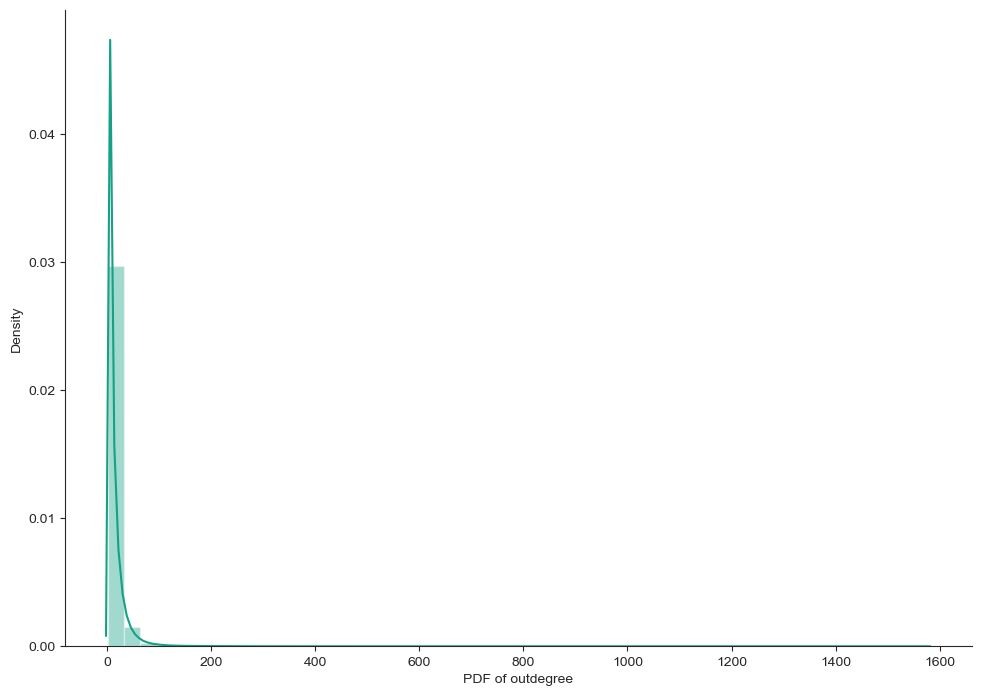

In [25]:
%matplotlib inline
sns.set_style('ticks')
fig, ax=plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(in_out_degree_sort, color='#16A085')
plt.xlabel("PDF of outdegree")
sns.despine()

In [26]:
print("Min of no of followers + followings is: ", in_out_degree.min())

Min of no of followers + followings is:  1


In [27]:
print(np.sum(in_out_degree==in_out_degree.min()), 'persons having minimum no of followers and followings.')

334291 persons having minimum no of followers and followings.


In [28]:
print("Max of no of followers + followings is: ", in_out_degree.max())

Max of no of followers + followings is:  1579


In [29]:
print(np.sum(in_out_degree==in_out_degree.max()), 'persons having maximum no of followers and followings.')

1 persons having maximum no of followers and followings.


In [30]:
print("No of persons having followers + followings less than 10 are: ", np.sum(in_out_degree<10))


No of persons having followers + followings less than 10 are:  1320326


In [31]:
print("No of weakly connected components: ", len(list(nx.weakly_connected_components(g))))

No of weakly connected components:  45558


In [32]:
#print(list(nx.weakly_connected_components(g))[0])
      

In [33]:
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count +=1
print("Weakly connected components with 2 nodes are: ", count)  

Weakly connected components with 2 nodes are:  32195


<h3> 2. Posing the Problem as Binary Classification Problem</h3>

<h4> 2.1. Generating Some Edges Which are not Present in Graph for Supervised Learning </h4>
Generated Bad links which are not in given graph and whose shortest path is greater than 2.

In [34]:
%%time
#Generating Bad links/edges from a given graph
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r=csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges=dict()
    for edge in r:
        edges[(edge[0],edge[1])]=1
        
    missing_edges=set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp=edges.get((a,b),-1)
        if tmp==-1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a, target=b)>2:
                    missing_edges.add((a,b))
                else:
                    continue
            except:
                missing_edges.add((a,b))
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges=pickle.load(open('data/after_eda/missing_edges_final.p','rb'))
    
                
        

CPU times: user 1.95 s, sys: 1.07 s, total: 3.02 s
Wall time: 3.55 s


In [35]:
print(len(missing_edges))

9437519


<h4>2.2. Training and Test Data split</h4>
<ul>
    <li>Removed edges from graph and used as test data</li>
    <li>After removing, use that graph for creating features for train and test data</li>
</ul>

In [36]:
from sklearn.model_selection import train_test_split

if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos=pd.read_csv('data/train.csv')
    df_neg=pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    print("Number of nodes in the graph with edges: ",df_pos.shape[0])
    print("Number of nodes in the graph without edges: ",df_neg.shape[0])
    #Train-Test split(80-20)
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    del missing_edges        

In [37]:
positive_train_nodes=pd.read_csv('data/after_eda/train_pos_after_eda.csv')
negative_train_nodes=pd.read_csv('data/after_eda/train_neg_after_eda.csv')
positive_test_nodes=pd.read_csv('data/after_eda/test_pos_after_eda.csv')
negative_test_nodes=pd.read_csv('data/after_eda/test_neg_after_eda.csv')
print("Number of nodes in the train data graph with edges", positive_train_nodes.shape[0])
print("Number of nodes in the train data graph without edges",negative_train_nodes.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", positive_test_nodes.shape[0])
print("Number of nodes in the test data graph without edges",negative_test_nodes.shape[0])

Number of nodes in the train data graph with edges 7550014
Number of nodes in the train data graph without edges 7550014
Number of nodes in the test data graph with edges 1887503
Number of nodes in the test data graph without edges 1887503


In [38]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))
    #finding the unique nodes in both train and test graphs
    train_nodes_pos=set(train_graph.nodes())
    test_nodes_pos=set(test_graph.nodes())
    trY_teY=len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN=len(train_nodes_pos-test_nodes_pos)
    teY_trN=len(test_nodes_pos-train_nodes_pos)
    print("Number of people common in train and test--",trY_teY)
    print("Number of people present in train but not in test data--",trY_teN)
    print("Number of people present in test but not in train data--",teY_trN)
    print("% of people present in test but not in train is {}".format(teY_trN/len(test_nodes_pos)*100))
    
    
    

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
Number of people common in train and test-- 1063125
Number of people present in train but not in test data-- 717597
Number of people present in test but not in train data-- 81498
% of people present in test but not in train is 7.1200735962845405


<b>Since there are 7.12% of edges which are in test data but not in train data, therefore we have coldstart problem here.</b>

In [39]:
#final train and test datasets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and\
    (not os.path.isfile('data/after_eda/test_after_eda.csv')) and\
    (not os.path.isfile('data/after_eda/train_y.csv')) and\
    (not os.path.isfile('data/after_eda/test_y.csv')) and\
    (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and\
    (os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and\
    (os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and\
    (os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos=pd.read_csv('data/after_eda/train_pos_after_eda.csv',names=['source_node','destination_node'])
    X_test_pos=pd.read_csv('data/after_eda/test_pos_after_eda.csv',names=['source_node','destination_node'])
    X_train_neg=pd.read_csv('data/after_eda/train_neg_after_eda.csv',names=['source_node','destination_node'])
    X_test_neg=pd.read_csv('data/after_eda/test_neg_after_eda.csv',names=['source_node','destination_node'])
    print("="*60)
    print("Number of nodes in the train data graph with edges: ",X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges: ",X_train_neg.shape[0])
    print("="*60)
    print("Number of nodes in the test data graph with edges: ",X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges: ",X_test_neg.shape[0])
    X_train=X_train_pos.append(X_train_neg,ignore_index=True)
    y_train=np.concatenate((y_train_pos, y_train_neg))
    X_test=X_test_pos.append(X_test_neg,ignore_index=True)
    y_test=np.concatenate((y_test_pos, y_test_neg))
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False, index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False, index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False, index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False, index=False)
    
    
    




In [40]:
X_train=pd.read_csv('data/after_eda/train_after_eda.csv')
y_train=pd.read_csv('data/train_y.csv')
X_test= pd.read_csv('data/after_eda/test_after_eda.csv')
y_test=pd.read_csv('data/test_y.csv')
print("Data points in  train data: ", X_train.shape)
print("Data points in  test data: ", X_test.shape)
print("Shape of the target variable in train data: ", y_train.shape)
print("Shape of the target variable in test data: ", y_test.shape)

Data points in  train data:  (15100029, 2)
Data points in  test data:  (3775007, 2)
Shape of the target variable in train data:  (15100029, 1)
Shape of the target variable in test data:  (3775007, 1)
